In [1]:
import os
os.chdir('../')

In [11]:
# dcgan_reproduction/train.py
import random, pathlib, datetime
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Subset

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [3]:
from models.Generator import Generator
from models.Discriminator import Discriminator

In [4]:
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Traning

## Parameters

In [5]:
SEED = 1337
random.seed(SEED); torch.manual_seed(SEED); np.random.seed(SEED)

data = 'imagenet_onek'

IMG_SIZE = 64
BATCH    = 128
EPOCHS   = 100
NZ       = 100
LR       = 2e-4
BETA1    = 0.5
LABEL_FRAC = 0.10

ROOT     = pathlib.Path("./")
DATA_DIR = ROOT/"data"
RES_DIR  = ROOT/f"results/{data}"; RES_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR  = ROOT/f"results/{data}/model"; MODEL_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Device:", DEVICE)

Device: mps


## Data Loading

In [ ]:
# 1) point this at your imagenet_onek folder
IMAGENET_ROOT = f"./data/{data}"

# 2) create the usual DCGAN transforms
IMG_SIZE = 64
BATCH    = 256
transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    # normalize each RGB channel to [-1,1] for Tanh()
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

# 3) wrap it in an ImageFolder
train_ds = ImageFolder(
    root=IMAGENET_ROOT,
    transform=transform
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

# sanity check:
print(f"Found {len(train_ds)} images in {len(train_ds.classes)} classes")
batch, labels = next(iter(train_loader))
print("batch.shape:", batch.shape)   # should be (BATCH, 3, IMG_SIZE, IMG_SIZE)
print("labels.shape:", labels.shape) # should be (BATCH,)

## Model Training

In [6]:
# build your nets for 3-channel images
netG = Generator(nz=NZ, ngf=64, nc=3).to(DEVICE)
netD = Discriminator(nc=3, ndf=64).to(DEVICE)
netG.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if hasattr(m,'weight') and m.weight is not None else None)
netD.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if hasattr(m,'weight') and m.weight is not None else None)

criterion = nn.BCELoss()
optD = optim.AdamW(netD.parameters(), lr=LR, betas=(BETA1,0.999), weight_decay=1e-4)
optG = optim.AdamW(netG.parameters(), lr=LR, betas=(BETA1,0.999), weight_decay=1e-4)

fixed_noise = torch.randn(64, NZ, 1, 1, device=DEVICE)

In [ ]:
# ─── Training ────────────────────────────────────────────────────────────────
print("===> Training")
for epoch in range(1, EPOCHS+1):
    for i, (real,_ ) in enumerate(train_loader):
        
        # Train D
        netD.zero_grad()
        real       = real.to(DEVICE); b=real.size(0)
        label_real = torch.ones(b, device=DEVICE)
        loss_real  = criterion(netD(real).view(-1), label_real)

        noise      = torch.randn(b, NZ,1,1, device=DEVICE)
        fake       = netG(noise)
        label_fake = torch.zeros(b, device=DEVICE)
        loss_fake  = criterion(netD(fake.detach()).view(-1), label_fake)
        loss_D     = loss_real + loss_fake
        loss_D.backward(); optD.step()

        # Train G
        netG.zero_grad()
        loss_G    = criterion(netD(fake).view(-1), label_real)  # want ones
        loss_G.backward(); optG.step()

        if i%100==0:
            print(f"[E{epoch}/{EPOCHS}] [{i}/{len(train_loader)}] D:{loss_D.item():.3f} G:{loss_G.item():.3f}")
            
    # save epoch samples
    with torch.no_grad():
        vutils.save_image(netG(fixed_noise).cpu(), RES_DIR/f"fake_epoch_{epoch:03d}.png", normalize=True)

In [ ]:
print("===> Saving checkpoints")
torch.save(netG.state_dict(), MODEL_DIR/"netG_final.pth")
torch.save(netD.state_dict(), MODEL_DIR/"netD_final.pth")

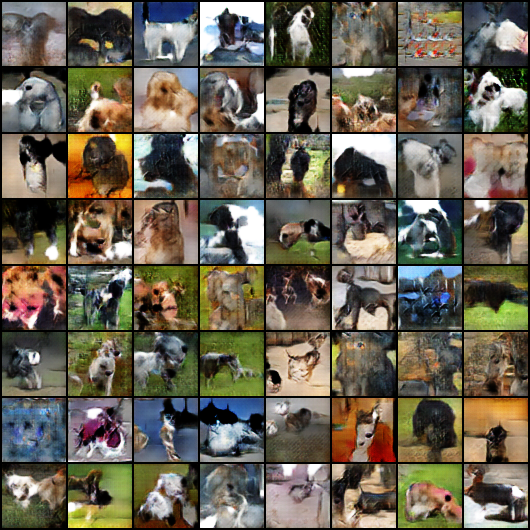

# Evaluation

In [7]:
# 1) Choose where to store (or load) the data
DATA_DIR = "./data/cifar10"

# 2) Define your transforms (resize only if you need a larger input)
BATCH = 128
transform = T.Compose([
    T.Resize(64),           # ← add this
    T.CenterCrop(64),       # ← and this (optional if already square)
    T.ToTensor(),
    # normalize each channel to zero mean, unit variance
    T.Normalize((0.4914, 0.4822, 0.4465),
                (0.2470, 0.2435, 0.2616)),
])

# 3) Download CIFAR10 train + test
train_set = dset.CIFAR10(root=DATA_DIR,
                         train=True,
                         download=True,
                         transform=transform)
test_set  = dset.CIFAR10(root=DATA_DIR,
                         train=False,
                         download=True,
                         transform=transform)

# 4) Wrap in DataLoader
train_loader = DataLoader(train_set,
                          batch_size=BATCH,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True)
test_loader  = DataLoader(test_set,
                          batch_size=BATCH,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True)

# 5) Sanity check
print(f"Training images: {len(train_set)}, Test images: {len(test_set)}")
imgs, labels = next(iter(train_loader))
print("batch.shape:", imgs.shape)    # expect (BATCH, 3, 32, 32)
print("labels.shape:", labels.shape) # expect (BATCH,)

Files already downloaded and verified
Files already downloaded and verified
Training images: 50000, Test images: 10000
batch.shape: torch.Size([128, 3, 64, 64])
labels.shape: torch.Size([128])


## Quantitative evaluation

In [12]:
labels_per_class = 400
img_size= 64 
batch= 256
C=1.0

In [9]:
# ----------------------
# Feature extractor
# ----------------------
POOL = nn.AdaptiveMaxPool2d((4, 4))
@torch.no_grad()
def extract_feats(loader):
    feats, labels = [], []
    for x, y in loader:
        x = x.to(DEVICE)
        h = x
        acts = []
        for layer in netD.main:
            h = layer(h)
            if isinstance(layer, nn.Conv2d) and h.shape[2] >= 4:
                acts.append(POOL(h).cpu())
        pooled = torch.cat([a.flatten(1) for a in acts], 1)
        feats.append(pooled)
        labels.append(y.numpy())
    return np.concatenate(feats), np.concatenate(labels)

# ----------------------
# Prepare data for SVM
# ----------------------
X_train, y_train = extract_feats(train_loader)
X_test,  y_test  = extract_feats(test_loader)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

In [13]:
# ----------------------
# Full-data linear SVM
# ----------------------

# hinge → linear SVM; parallelized; early stopping via tol
clf = SGDClassifier(
    loss='hinge',
    penalty='l2',
    alpha=1.0/len(y_train)/C,  # match L2 penalty C
    max_iter=1000,
    tol=1e-3,
    n_jobs=-1,
    random_state=42)

clf.fit(X_train_s, y_train)
acc_full = clf.score(X_test_s, y_test) * 100
print("SGD-SVM accuracy:", acc_full)
msg_full = (f"{datetime.datetime.now()}: Full-data linear-SVM (CIFAR-10) = {acc_full:.2f}%\n")
print(msg_full)

SGD-SVM accuracy: 67.97
2025-05-09 00:36:13.075541: Full-data linear-SVM (CIFAR-10) = 67.97%



**Comments:** 

**Therefore DCGAN, .**

In [14]:
# ----------------------
# Limited-shot (per-class) SVM
# ----------------------
if labels_per_class > 0:
    # sample equal labels per class
    train_set = train_loader.dataset
    class_idxs = {c: [] for c in set(y_train)}
    for idx, (_, lbl) in enumerate(train_set):
        class_idxs[int(lbl)].append(idx)
    selected = []
    for c, inds in class_idxs.items():
        selected += list(np.random.choice(inds, labels_per_class, replace=False))
    limited_loader = DataLoader(Subset(train_set, selected), batch, shuffle=False)
    X_lim, y_lim = extract_feats(limited_loader)
    X_lim_s = scaler.transform(X_lim)
    clf_lim = SGDClassifier(loss='hinge', penalty='l2', alpha=1.0/len(y_lim)/C, max_iter=1000, tol=1e-3, n_jobs=-1, random_state=42)
    clf_lim.fit(X_lim_s, y_lim)
    acc_lim = accuracy_score(y_test, clf_lim.predict(X_test_s)) * 100
    msg_lim = (f"{datetime.datetime.now()}: {labels_per_class} labels/class linear-SVM = {acc_lim:.2f}%\n")
    print(msg_lim)
    (RES_DIR / "eval_limited.txt").write_text(msg_lim)

2025-05-09 00:38:01.381469: 400 labels/class linear-SVM = 56.60%



# Overall Comments 

- 